## Motivation

Every two years, every member of the United States House of Representatives is up for election. After being elected, members of the House are given a set budget from the legislature itself to hire staff, buy office equipment, and defray other costs of legislating and addressing constituent concerns. While each office gets the same amount of money from Congress to spend on these purposes, congressional offices have discretion over how that allowance is actually spent, and we would like to see whether some spending patterns are associated with higher political success. 

# Getting/Formatting the Data

For this project, we decided to use the [House Office Expenditure Data](https://www.propublica.org/datastore/dataset/house-office-expenditures) from ProPublica as it contains well formatted data about house expenditures from 2009 to 2018. The main downside of this dataset is that it is missing data from the most recent midterm election, but we still have almost 10 years of data to work with.

To programatically access the datasets we are working with, we have included copies here [repository](https://github.com/AndrewTrackim/cmsc320-final/raw/master/house-expenditure/).

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
# just finna test with one of the files to see what happens
frames = []

#automate the dataframes from 2010 to 2017
for i in range(2010, 2021):
    for j in range(1, 5):
        df = pd.read_csv('./house-expenditure/' + str(i) + 'Q' + str(j) +'-house-disburse-detail.csv', thousands=',', encoding = 'unicode_escape')
        df.dropna(subset = ['BIOGUIDE_ID'], inplace=True)
        if not {'CATEGORY'}.issubset(df.columns): # For whatever reason, 2018Q2 has its category column mislabeled. 
            df.rename(columns={"SORT SUBTOTAL DESCRIPTION" : "CATEGORY"}, inplace=True)
        df["QUARTER"] = str(i) + 'Q' + str(j)
        frames.append(df)

house_data = pd.concat(frames)
# house_data

<ipython-input-87-d5e057bcfbe3>:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./house-expenditure/' + str(i) + 'Q' + str(j) +'-house-disburse-detail.csv', thousands=',', encoding = 'unicode_escape')
<ipython-input-87-d5e057bcfbe3>:9: DtypeWarning: Columns (2,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./house-expenditure/' + str(i) + 'Q' + str(j) +'-house-disburse-detail.csv', thousands=',', encoding = 'unicode_escape')
<ipython-input-87-d5e057bcfbe3>:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./house-expenditure/' + str(i) + 'Q' + str(j) +'-house-disburse-detail.csv', thousands=',', encoding = 'unicode_escape')


[election data](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/IG0UN2)

In [88]:
election_data = pd.read_csv('./house-expenditure/1976-2020-house.csv')

# filter out the years before 2009 and after 2018
election_data = election_data[election_data['year'] >= 2009]
election_data = election_data[election_data['year'] <= 2020]

election_data

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version,fusion_ticket
22553,2010,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,NaN,False,DAVID WALTER,CONSTITUTION,False,TOTAL,26357,156281,False,20220331,False
22554,2010,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,NaN,False,JO BONNER,REPUBLICAN,False,TOTAL,129063,156281,False,20220331,False
22555,2010,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,NaN,False,WRITEIN,NaN,True,TOTAL,861,156281,False,20220331,False
22556,2010,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,NaN,False,BOBBY BRIGHT,DEMOCRAT,False,TOTAL,106865,219028,False,20220331,False
22557,2010,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,NaN,False,MARTHA ROBY,REPUBLICAN,False,TOTAL,111645,219028,False,20220331,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31098,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,False,LYNNETTE GREY BULL,DEMOCRAT,False,TOTAL,66576,278503,False,20220331,False
31099,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,False,OVERVOTES,NaN,False,TOTAL,1274,278503,False,20220331,False
31100,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,False,RICHARD BRUBAKER,LIBERTARIAN,False,TOTAL,10154,278503,False,20220331,False
31101,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,False,UNDERVOTES,NaN,False,TOTAL,6337,278503,False,20220331,False


Try to figure out what categories we are working with and how these categories should be group into broader categories

In [89]:
from collections import defaultdict
categories = defaultdict(lambda: 0)
def add_set(row):
      categories[row['CATEGORY']] += 1

#apply add_set to the house_data
house_data.apply(add_set, axis = 1)
categories

defaultdict(<function __main__.<lambda>()>,
            {'FRANKED MAIL': 119015,
             'PERSONNEL COMPENSATION': 495108,
             'TRAVEL': 874270,
             'RENT, COMMUNICATION, UTILITIES': 598709,
             'PRINTING AND REPRODUCTION': 165614,
             'OTHER SERVICES': 196175,
             'SUPPLIES AND MATERIALS': 697444,
             'EQUIPMENT': 131549,
             'PERSONNEL BENEFITS': 122,
             'TRANSPORTATION OF THINGS': 695,
             'RENT COMMUNICATION UTILITIES': 18459,
             'RENT  COMMUNICATION  UTILITIES': 299339,
             'BENEFITS TO FORMER PERSONNEL': 5})

In [90]:
replace = {
    'RENT  COMMUNICATION  UTILITIES': 'RENT, COMMUNICATION, UTILITIES',
    'RENT COMMUNICATION UTILITIES': 'RENT, COMMUNICATION, UTILITIES'
}
house_data.replace(to_replace=replace, value=None, inplace=True)

In [91]:
categories = defaultdict(lambda: 0)
def add_set(row):
      categories[row['CATEGORY']] += 1
      
house_data.apply(add_set, axis = 1)
str(categories)

"defaultdict(<function <lambda> at 0x7fb2b442a0d0>, {'FRANKED MAIL': 119015, 'PERSONNEL COMPENSATION': 495108, 'TRAVEL': 874270, 'RENT, COMMUNICATION, UTILITIES': 598709, 'PRINTING AND REPRODUCTION': 165614, 'OTHER SERVICES': 196175, 'SUPPLIES AND MATERIALS': 697444, 'EQUIPMENT': 131549, 'PERSONNEL BENEFITS': 122, 'TRANSPORTATION OF THINGS': 695, 'RENT COMMUNICATION UTILITIES': 18459, 'RENT  COMMUNICATION  UTILITIES': 299339, 'BENEFITS TO FORMER PERSONNEL': 5})"

In [92]:
import requests
from bs4 import BeautifulSoup
raw = requests.get("https://www.congress.gov/help/field-values/member-bioguide-ids")
soup = BeautifulSoup(raw.text, 'lxml')
table = soup.find('table')

# Since the entire thing is a formatted table, read it directly into a pandas dataframe
tabledf = pd.read_html(str(table))
tabledf = tabledf[0]
tabledf.dropna(subset = ['Member'], inplace=True)
tabledf.reset_index(drop=True, inplace=True)
members = tabledf['Member'].str.extractall("(.*), (.*) \((.*) - (.*)\)")

members.reset_index(drop=True, inplace=True)
members.rename(columns={0 : 'LASTNAME', 1: "FIRSTNAME", 2: "PARTY", 3: "STATE"}, inplace=True)
members['BIOGUIDE_ID'] = tabledf['Member ID']
members

,LASTNAME,FIRSTNAME,PARTY,STATE,BIOGUIDE_ID
0,Abdnor,James,Republican,South Dakota,A000009
1,Abercrombie,Neil,Democratic,Hawaii,A000014
2,Abourezk,James,Democratic,South Dakota,A000017
3,Abraham,Ralph Lee,Republican,Louisiana,A000374
4,Abraham,Spencer,Republican,Michigan,A000355
...,...,...,...,...,...
2422,Zinke,Ryan K.,Republican,Montana,Z000018
2423,Zion,Roger H.,Republican,Indiana,Z000010
2424,Zorinsky,Edward,Democratic,Nebraska,Z000013
2425,Zschau,Edwin V. W.,Republican,California,Z000014


Here we are importing data on the number of terms each congress member has served, we are being carfull to not count terms served after the period we are analysing.

In [93]:
import datetime

term_data = []
column_names = ['BIOGUIDE_ID','TERMS']

for url in ['https://theunitedstates.io/congress-legislators/legislators-current.json','https://theunitedstates.io/congress-legislators/legislators-historical.json']:
    r = requests.get(url)
    json_data = r.json()

    for json_el in json_data:
        number_of_terms = 0
        for term in json_el['terms']:
            start_date = datetime.datetime.strptime(term['start'], '%Y-%m-%d')
            # Make sure we are not looking at terms served after the period we are analysing
            if start_date.year < 2020:
                number_of_terms += 1
        term_data.append([json_el['id']['bioguide'], len(json_el['terms'])])

us_io_data = pd.DataFrame(term_data, columns=column_names)
us_io_data

,BIOGUIDE_ID,TERMS
0,B000944,10
1,C000127,5
2,C000141,13
3,C000174,9
4,C001070,3
...,...,...
12585,H001088,2
12586,Y000033,25
12587,F000449,9
12588,V000132,5


## k-means

In [94]:
import numpy as np
quarters = house_data['QUARTER'].unique()
categories = house_data['CATEGORY'].unique()

quarter = quarters[4]
hd_by_quarter = house_data[house_data['QUARTER'] == quarter]
bio_ids = hd_by_quarter['BIOGUIDE_ID'].unique()


spending_per_candidate = hd_by_quarter.groupby(['BIOGUIDE_ID','CATEGORY'])['AMOUNT'].sum()
spending_data = []
for bio_id in bio_ids:
    row = [bio_id]
    for category in categories:
        if category in spending_per_candidate[bio_id]:
            row.append(spending_per_candidate[bio_id][category])
        else:
            row.append(0)
    spending_data.append(row)
quarter_spending_df = pd.DataFrame(spending_data,columns = ["BIOGUIDE_ID"] + categories.tolist())
# quarter_spending_df = quarter_spending_df.dropna(axis='columns')
# quarter_spending_df.dropna(subset = ['BIOGUIDE_ID']))
quarter_spending_df
# spending_per_candidate.to_csv('spending_per_candidate_' + quarter + '.csv')

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL
0,A000014,0.00,-16.67,0.00,0.00,0.00,0.00,0.00,0.00,0,0.0,0,0,0
1,A000022,1909.79,221917.86,4408.29,42452.47,3351.43,14544.05,16893.16,29771.60,0,0.0,0,0,0
2,A000366,544.03,153141.65,5278.86,11755.74,3088.08,16290.80,3718.37,1154.26,0,0.0,0,0,0
3,A000055,1596.30,241025.00,10240.27,20557.94,2207.96,31803.95,10611.37,466.50,0,0.0,0,0,0
4,A000364,-1025.59,63958.87,2752.45,1535.46,0.00,75.00,118.85,2500.00,0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,Y000062,1516.09,251042.50,16880.90,19938.93,3095.85,9820.06,16012.77,1585.11,0,0.0,0,0,0
536,Y000063,915.11,138985.01,9307.80,11831.87,2140.50,9601.80,17129.45,1925.10,0,0.0,0,0,0
537,Y000031,9060.30,225343.06,13973.82,22532.63,2197.04,13195.70,21175.40,8000.64,0,0.0,0,0,0
538,Y000033,1291.25,254234.48,14910.34,53791.82,2991.34,36233.64,27649.41,12792.63,0,0.0,0,0,0


In [95]:
# Left join the spending data with the candidate data
spending_member_info = quarter_spending_df.merge(members, on="BIOGUIDE_ID")
spending_member_info = spending_member_info.merge(us_io_data, on="BIOGUIDE_ID")
spending_member_info

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL,LASTNAME,FIRSTNAME,PARTY,STATE,TERMS
0,A000014,0.00,-16.67,0.00,0.00,0.00,0.00,0.00,0.00,0,0.0,0,0,0,Abercrombie,Neil,Democratic,Hawaii,11
1,A000022,1909.79,221917.86,4408.29,42452.47,3351.43,14544.05,16893.16,29771.60,0,0.0,0,0,0,Ackerman,Gary L.,Democratic,New York,15
2,A000366,544.03,153141.65,5278.86,11755.74,3088.08,16290.80,3718.37,1154.26,0,0.0,0,0,0,Adams,Sandy,Republican,Florida,1
3,A000055,1596.30,241025.00,10240.27,20557.94,2207.96,31803.95,10611.37,466.50,0,0.0,0,0,0,Aderholt,Robert B.,Republican,Alabama,13
4,A000364,-1025.59,63958.87,2752.45,1535.46,0.00,75.00,118.85,2500.00,0,0.0,0,0,0,Adler,John H.,Democratic,New Jersey,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,Y000062,1516.09,251042.50,16880.90,19938.93,3095.85,9820.06,16012.77,1585.11,0,0.0,0,0,0,Yarmuth,John A.,Democratic,Kentucky,8
536,Y000063,915.11,138985.01,9307.80,11831.87,2140.50,9601.80,17129.45,1925.10,0,0.0,0,0,0,Yoder,Kevin,Republican,Kansas,4
537,Y000031,9060.30,225343.06,13973.82,22532.63,2197.04,13195.70,21175.40,8000.64,0,0.0,0,0,0,Young,C. W. Bill,Republican,Florida,22
538,Y000033,1291.25,254234.48,14910.34,53791.82,2991.34,36233.64,27649.41,12792.63,0,0.0,0,0,0,Young,Don,Republican,Alaska,25


In [96]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
# train, test = train_test_split(spending_member_info[categories], test_size=0.2)
kmeans_model = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
kmeans_trained = kmeans_model.fit(spending_member_info[categories])
# kmeans_trained.cluster_centers_

clusters = kmeans_trained.predict(spending_member_info[categories])
for i in list(set(clusters)):
# i=0
    print("Cluster:",i)
    print(spending_member_info[["STATE","BIOGUIDE_ID","LASTNAME","TERMS"]][clusters==i].to_string())
    print("")
# print(spending_member_info[["PARTY","STATE"]][clusters==i].groupby("STATE").count())

Cluster: 0
                    STATE BIOGUIDE_ID            LASTNAME  TERMS
21                  Texas     B000213              Barton     17
25             California     B000287             Becerra     13
28                 Nevada     B001231             Berkley      7
35                Georgia     B000490  Bishop, Sanford D.     15
48                   Iowa     B000652             Boswell      8
53           Pennsylvania     B001227               Brady     11
69               Michigan     C000071                Camp     12
75             California     C001036               Capps     10
76          Massachusetts     C001037             Capuano     10
77             California     C001050             Cardoza      5
104              Michigan     C000714       Conyers, John     27
105             Tennessee     C000754              Cooper     16
119              Illinois     D000096               Davis     13
122            California     D000598               Davis     10
125           

In [97]:
print(spending_member_info[["PARTY","LASTNAME","STATE"]][clusters==6].to_string())

          PARTY           LASTNAME                     STATE
1    Democratic           Ackerman                  New York
9    Democratic            Andrews                New Jersey
22   Republican               Bass             New Hampshire
23   Democratic               Bass                California
31   Republican            Biggert                  Illinois
33   Republican          Bilirakis                   Florida
46   Democratic           Bordallo                      Guam
52   Republican              Brady                     Texas
66   Democratic        Butterfield            North Carolina
68   Republican            Calvert                California
82   Republican             Carter                     Texas
83   Republican            Cassidy                 Louisiana
85   Democratic             Castor                   Florida
92   Democratic          Cicilline              Rhode Island
103  Democratic           Connolly                  Virginia
107  Democratic         

In [98]:
len(spending_member_info[["PARTY","LASTNAME"]][clusters==1])

74

## K-NN

In [99]:
import numpy as np
quarters = house_data['QUARTER'].unique()
categories = house_data['CATEGORY'].unique()
spending_data = []

for quarter in quarters:
    hd_by_quarter = house_data[house_data['QUARTER'] == quarter]
    bio_ids = hd_by_quarter['BIOGUIDE_ID'].unique()

    spending_per_candidate = hd_by_quarter.groupby(['BIOGUIDE_ID','CATEGORY'])['AMOUNT'].sum()
        
    for bio_id in bio_ids:
        row = [bio_id]
        for category in categories:
            if category in spending_per_candidate[bio_id]:
                row.append(spending_per_candidate[bio_id][category])
            else:
                row.append(0)
        spending_data.append(row)
quarter_spending_df = pd.DataFrame(spending_data,columns = ["BIOGUIDE_ID"] + categories.tolist())
# quarter_spending_df = quarter_spending_df.dropna(axis='columns')
# quarter_spending_df.dropna(subset = ['BIOGUIDE_ID']))
quarter_spending_df
# spending_per_candidate.to_csv('spending_per_candidate_' + quarter + '.csv')

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL
0,A000014,1498.61,259540.31,10891.59,21084.39,43.90,8348.02,4661.75,981.30,0.0,0.0,0.0,0.00,0.0
1,A000022,21011.90,242972.84,3655.22,33422.01,9794.18,21341.00,17776.34,2033.33,0.0,0.0,0.0,0.00,0.0
2,A000055,1671.92,264937.16,10360.45,19145.14,2130.92,11644.95,8005.85,601.50,0.0,0.0,0.0,0.00,0.0
3,A000364,85906.29,199660.40,7925.65,27119.41,75410.20,30479.70,6095.27,3894.33,0.0,0.0,0.0,0.00,0.0
4,A000358,40746.81,259704.20,6721.87,24703.34,45627.10,12367.41,6997.48,3610.12,0.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20514,W000827,-48.90,343750.00,3554.82,0.00,612.92,20806.60,330.84,385771.82,0.0,0.0,0.0,63428.86,0.0
20515,Y000062,279.42,554398.70,3576.12,0.00,38.00,6924.42,30705.18,568213.36,0.0,0.0,0.0,112862.60,0.0
20516,Y000065,740.14,702125.06,4916.98,0.00,800.00,3151.28,4912.34,822292.96,0.0,0.0,0.0,37383.60,0.0
20517,Y000033,105.16,764444.52,55760.86,0.00,79.90,37800.00,3949.54,915982.56,0.0,0.0,0.0,42935.26,0.0


In [100]:
# Left join the spending data with the candidate data
spending_member_info = quarter_spending_df.merge(members, on="BIOGUIDE_ID")
spending_member_info = spending_member_info.merge(us_io_data, on="BIOGUIDE_ID")
spending_member_info

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL,LASTNAME,FIRSTNAME,PARTY,STATE,TERMS
0,A000014,1498.61,259540.31,10891.59,21084.39,43.90,8348.02,4661.75,981.30,0.0,0.00,0.0,0.00,0.0,Abercrombie,Neil,Democratic,Hawaii,11
1,A000014,768.37,140136.13,5114.78,18945.34,124.82,10946.92,3398.35,580.34,0.0,0.00,0.0,0.00,0.0,Abercrombie,Neil,Democratic,Hawaii,11
2,A000014,0.00,0.00,0.00,0.00,640.45,2496.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,Abercrombie,Neil,Democratic,Hawaii,11
3,A000014,0.00,-16.67,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,Abercrombie,Neil,Democratic,Hawaii,11
4,A000014,0.00,0.00,-5.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,Abercrombie,Neil,Democratic,Hawaii,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20482,T000165,35312.72,445683.34,36157.54,0.00,30055.22,20781.50,4222.48,634252.12,0.0,0.00,0.0,26532.12,0.0,Tiffany,Thomas P.,Republican,Wisconsin,2
20483,T000165,939.02,538633.34,42774.30,0.00,70991.00,18570.00,7274.06,771577.42,0.0,0.00,0.0,61585.10,0.0,Tiffany,Thomas P.,Republican,Wisconsin,2
20484,J000020,55786.12,194099.78,3513.84,0.00,46506.30,15396.52,14604.66,399528.44,0.0,58.72,0.0,43081.78,0.0,Jacobs,Chris,Republican,New York,2
20485,J000020,490.08,413822.36,16107.64,0.00,1235.34,24090.32,31447.38,521498.22,0.0,28.92,0.0,22084.30,0.0,Jacobs,Chris,Republican,New York,2


### K-nn - Predicting party

Issolate just Democratic and Republican members as the other parties don't have enough data to train on.

In [101]:
spending_member_info_2_party_dup_mems = pd.concat([spending_member_info[spending_member_info["PARTY"] == 'Republican'], spending_member_info[spending_member_info["PARTY"] == 'Democratic']])
spending_member_info_2_party_dup_mems["PARTY"].unique()

array(['Republican', 'Democratic'], dtype=object)

In [102]:
spending_member_info_2_party = spending_member_info_2_party_dup_mems.groupby("BIOGUIDE_ID").mean()
spending_member_info_2_party = spending_member_info_2_party.merge(members, on="BIOGUIDE_ID")
spending_member_info_2_party

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL,TERMS,LASTNAME,FIRSTNAME,PARTY,STATE
0,A000014,453.396000,79931.954000,3200.274000,8005.946000,161.834000,4358.188000,1612.020000,312.328000,0.0,0.000000,0.000000,0.000000,0.0,11.0,Abercrombie,Neil,Democratic,Hawaii
1,A000022,7788.006667,193373.456667,3442.826000,25562.300667,4367.879333,11344.972667,10127.956667,3913.299333,0.0,62.866667,0.000000,0.000000,0.0,15.0,Ackerman,Gary L.,Democratic,New York
2,A000055,2354.593333,326544.238333,24328.341905,13332.801667,3321.446429,11944.112143,15603.744762,212749.775476,0.0,0.000000,571.451905,15803.909286,0.0,13.0,Aderholt,Robert B.,Republican,Alabama
3,A000210,10945.465714,178926.020952,3494.050476,26119.840476,6882.656667,12245.477143,5025.150000,5005.634762,0.0,0.000000,0.000000,0.000000,0.0,13.0,Andrews,Robert E.,Democratic,New Jersey
4,A000358,13886.653077,214088.965385,6301.306923,20012.550000,9924.551538,8219.811538,3919.610769,1554.232308,0.0,0.000000,0.000000,0.000000,0.0,6.0,Akin,W. Todd,Republican,Missouri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,Y000064,13135.199600,209062.036000,14528.366400,16534.750000,17906.093200,11071.945200,5417.384800,1834.870800,0.0,0.000000,720.305200,50.960400,0.0,4.0,Young,Todd,Republican,Indiana
866,Y000065,4116.539688,298805.577188,17447.323125,8825.123750,7179.720312,14188.968125,10682.153750,244929.378750,0.0,0.000000,484.918125,19315.641563,0.0,4.0,Yoho,Ted S.,Republican,Florida
867,Y000066,11272.579444,236393.313333,16917.312222,10016.435556,8820.207778,12847.712222,12529.895556,175452.861667,0.0,0.388889,947.271667,17889.126111,0.0,2.0,Young,David,Republican,Iowa
868,Z000017,22455.262917,362481.625833,13059.878333,7506.778333,19181.431667,19418.380417,8814.332083,374399.791250,0.0,106.994583,1232.522500,34375.121667,0.0,4.0,Zeldin,Lee M.,Republican,New York


Here we are making a KNN with default values to see if the model does better than random chance.

In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

x_train, x_test, y_train, y_test = train_test_split(spending_member_info_2_party[categories], spending_member_info_2_party["PARTY"])
knn_model = KNeighborsClassifier()
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.647016317016317

We get an accurary score higher than 50% which looks promising.

We can now try to tune the hyperparameters. Starting with the way points in the k-nn model are weighted. Uniform weighting gives all k nearest points equal weighting, while the distance weighting weighs points by the inverse of their distance. The default weight in scikit learn is uniform so we are testing the distance weighting method.

In [104]:
knn_model = KNeighborsClassifier(weights='distance')
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.6485081585081585

It looks like both weighting methods produce very similar accuracies. As a result, we will use the default that scikit learn uses as there is likely good reason it is the default and we do not have a good reason to change it.

Next we are going to look at the number of nearest neighbors and see how that changes our accuracy.

<ipython-input-105-6ea273826c0b>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


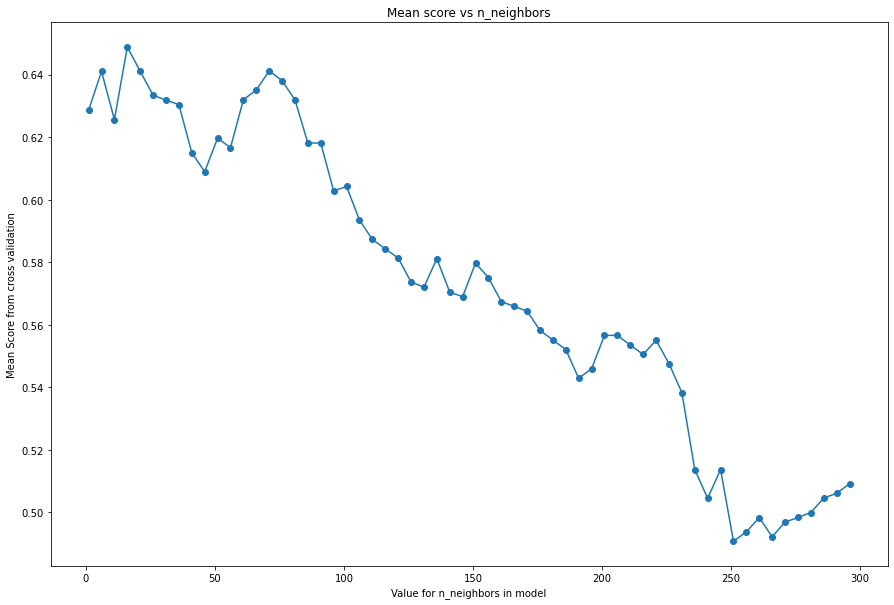

In [105]:
from sklearn.model_selection import GridSearchCV
knn_model = KNeighborsClassifier()
test_k = range(1,300+1,5)
params=[{
    'n_neighbors': test_k,
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()

# Code to change default plot size:
plt.rcParams['figure.figsize'] = [15, 10]

fig, ax = plt.subplots()
ax.plot(test_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()

From the graph it seems like the ideal number of neighbors is in the range between 10 and 50. We can do a grid search of all values in that range to better visualize the space.

<ipython-input-106-be3a5a5042be>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


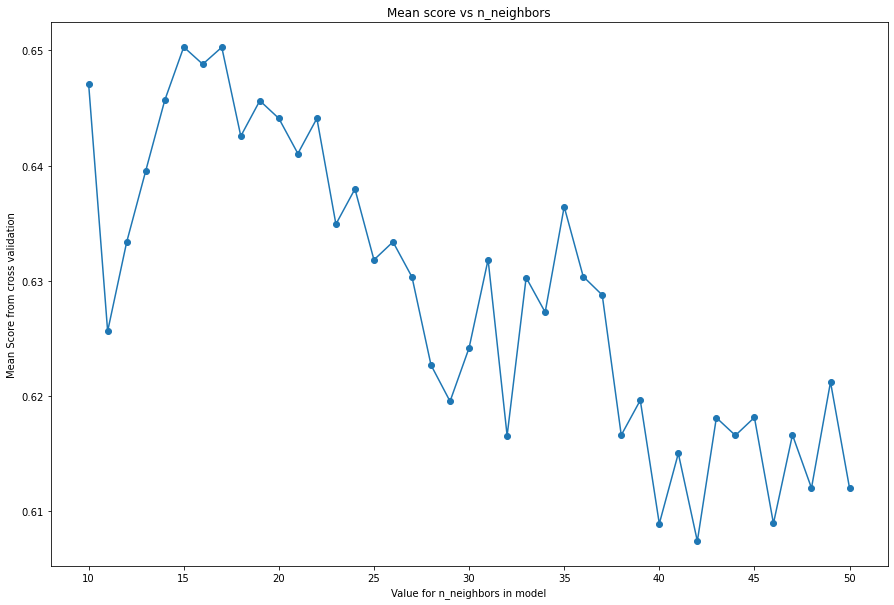

In [106]:
knn_model = KNeighborsClassifier()
test_k = range(10,50+1)
params=[{
    'n_neighbors': test_k,
    # 'weights': ['uniform', 'distance']
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()
tested_k = gs_knn.cv_results_['param_n_neighbors'].tolist()

fig, ax = plt.subplots()
ax.plot(tested_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()


In [107]:
max_score = max(result_k)
index_of_max = result_k.index(max_score)
optimal_k_val = tested_k[index_of_max]
optimal_k_val

15

There seems to be a peak in the data around $k=25$ so that will be the value for k we will use in the final model.

With these hyper parameters set, we can evaulate our model's performance on the test set.

In [108]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_k_val)
knn_trained = knn_model.fit(x_train, y_train)
knn_model.score(x_test,y_test)

0.6330275229357798

### K-nn - Predicting State

In [109]:
# Verifying we have enough data for each state

# state_count = {}
# for state in spending_member_info["STATE"].unique():
#     state_count[state] = sum(sum([spending_member_info["STATE"] == state]))
# state_count

We have a lot more data for states with more representitives

In [110]:
x_train, x_test, y_train, y_test = train_test_split(spending_member_info_2_party[categories],spending_member_info_2_party["STATE"])
knn_model = KNeighborsClassifier()
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

/home/arjun/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.07825174825174826

We get an accurary score higher than 1/56 which looks promising.

We can now try to tune the hyperparameters. Starting with the way points in the k-nn model are weighted. Uniform weighting gives all k nearest points equal weighting, while the distance weighting weighs points by the inverse of their distance. The default weight in scikit learn is uniform so we are testing the distance weighting method.

In [111]:
knn_model = KNeighborsClassifier(weights='distance')
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

/home/arjun/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.08130536130536131

It looks like both weighting methods produce very similar accuracies. As a result, we will use the default that scikit learn uses as there is likely good reason it is the default and we do not have a good reason to change it.

Next we are going to look at the number of nearest neighbors and see how that changes our accuracy.

/home/arjun/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
<ipython-input-112-210daaf7f6d5>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


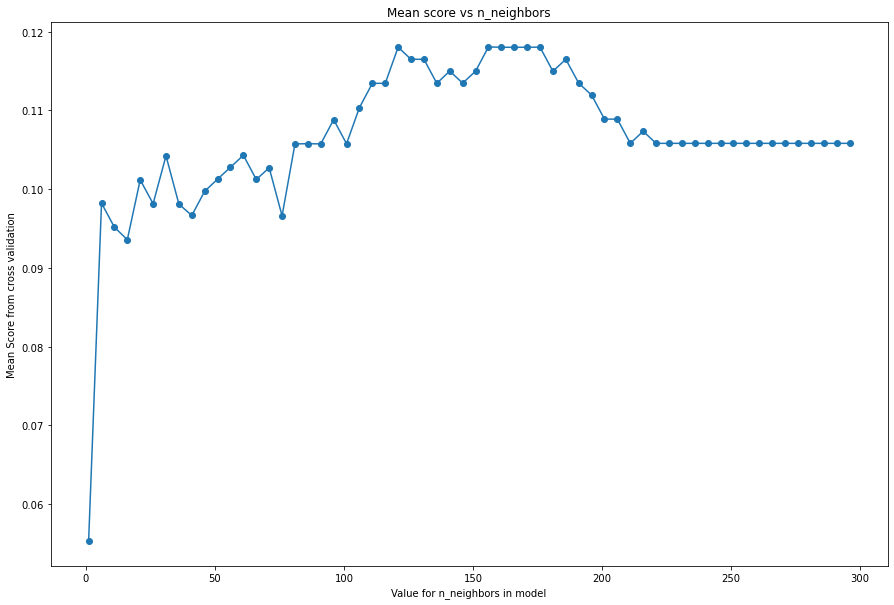

In [112]:
from sklearn.model_selection import GridSearchCV
knn_model = KNeighborsClassifier()
test_k = range(1,300+1,5)
params=[{
    'n_neighbors': test_k,
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()

fig, ax = plt.subplots()
ax.plot(test_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()

From the graph it seems like the ideal number of neighbors is in the range between 25 and 75. We can do a grid search of all values in that range to better visualize the space.

/home/arjun/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
<ipython-input-113-acdff45cd34f>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


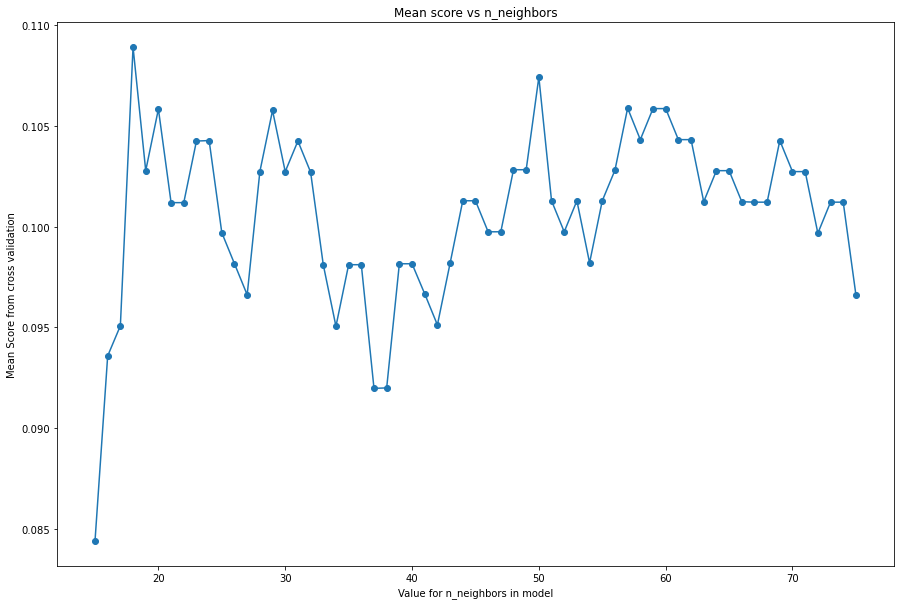

In [113]:
knn_model = KNeighborsClassifier()
test_k = range(15,75+1)
params=[{
    'n_neighbors': test_k,
    # 'weights': ['uniform', 'distance']
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()
tested_k = gs_knn.cv_results_['param_n_neighbors'].tolist()

fig, ax = plt.subplots()
ax.plot(tested_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()


In [114]:
max_score = max(result_k)
index_of_max = result_k.index(max_score)
optimal_k_val = tested_k[index_of_max]
optimal_k_val

18

There seems to be a peak in the data around $k = 52$ so that will be the value for k we will use in the final model.

With these hyper parameters set, we can evaulate our model's performance on the test set.

In [115]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_k_val)
knn_trained = knn_model.fit(x_train, y_train)
knn_model.score(x_test,y_test)

0.0871559633027523

This is a suprisingly high amount of accuracy. I believe this is actually a result of candidates having similar spending patterns over time, and since a canditate is likely to serve multiple terms for their state it makes sense that we can can predict state from spending patterns. To test this theory, I will see if we can predict a candidate based on their spending.

### K-nn - Candidate

In [116]:
bio_count = {}
for bio_id in spending_member_info["BIOGUIDE_ID"].unique():
    bio_count[bio_id] = sum(sum([spending_member_info["BIOGUIDE_ID"] == bio_id]))
bio_count

{'A000014': 5,
 'A000022': 15,
 'A000055': 42,
 'A000364': 6,
 'A000358': 13,
 'A000361': 18,
 'A000362': 14,
 'A000210': 21,
 'A000363': 6,
 'A000365': 16,
 'B001234': 14,
 'B001256': 24,
 'B000013': 25,
 'B001229': 7,
 'B001230': 14,
 'B001239': 6,
 'B001252': 22,
 'B000208': 14,
 'B000213': 35,
 'B001253': 9,
 'B000287': 31,
 'B001231': 16,
 'B000410': 16,
 'B000420': 8,
 'B001232': 12,
 'B000461': 15,
 'B001257': 42,
 'B001250': 42,
 'B000490': 42,
 'B001242': 23,
 'B001243': 36,
 'B000574': 42,
 'B000575': 5,
 'B001263': 9,
 'B000589': 25,
 'B001244': 20,
 'B001228': 15,
 'B001236': 8,
 'B001245': 38,
 'B001254': 15,
 'B000652': 16,
 'B000657': 7,
 'B001255': 28,
 'B000716': 5,
 'B000755': 42,
 'B001227': 36,
 'B001259': 22,
 'B001264': 6,
 'B001262': 22,
 'B001247': 6,
 'B000911': 29,
 'B001235': 5,
 'B001260': 42,
 'B001248': 42,
 'B001149': 16,
 'B001251': 42,
 'B001203': 7,
 'C000059': 42,
 'C000071': 23,
 'C001064': 21,
 'C001046': 24,
 'C001079': 7,
 'C001047': 23,
 'C001036

In [117]:
spending_member_info_candidates_arr = []
for bio_id in spending_member_info["BIOGUIDE_ID"].unique():
    count = sum(sum([spending_member_info["BIOGUIDE_ID"] == bio_id]))
    if count > 20:
        spending_member_info_candidates_arr.append(spending_member_info[spending_member_info["BIOGUIDE_ID"] == bio_id])
spending_member_info_candidates = pd.concat(spending_member_info_candidates_arr)
len(spending_member_info_candidates["BIOGUIDE_ID"].unique())

463

In [118]:
x_train, x_test, y_train, y_test = train_test_split(spending_member_info_candidates[categories],spending_member_info_candidates["BIOGUIDE_ID"])
knn_model = KNeighborsClassifier()
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.044166953860575404

In [119]:
knn_model = KNeighborsClassifier(weights='distance')
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.05637094884272344

<ipython-input-120-7f69219a2088>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


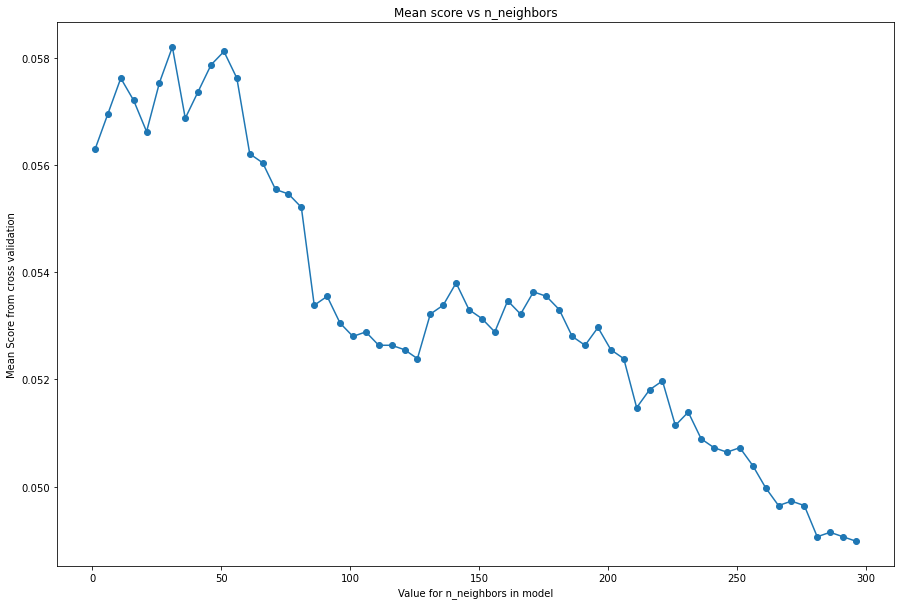

In [120]:
from sklearn.model_selection import GridSearchCV
knn_model = KNeighborsClassifier(weights='distance')
test_k = range(1,300+1,5)
params=[{
    'n_neighbors': test_k,
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()

fig, ax = plt.subplots()
ax.plot(test_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()

<ipython-input-121-540ada2706f5>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


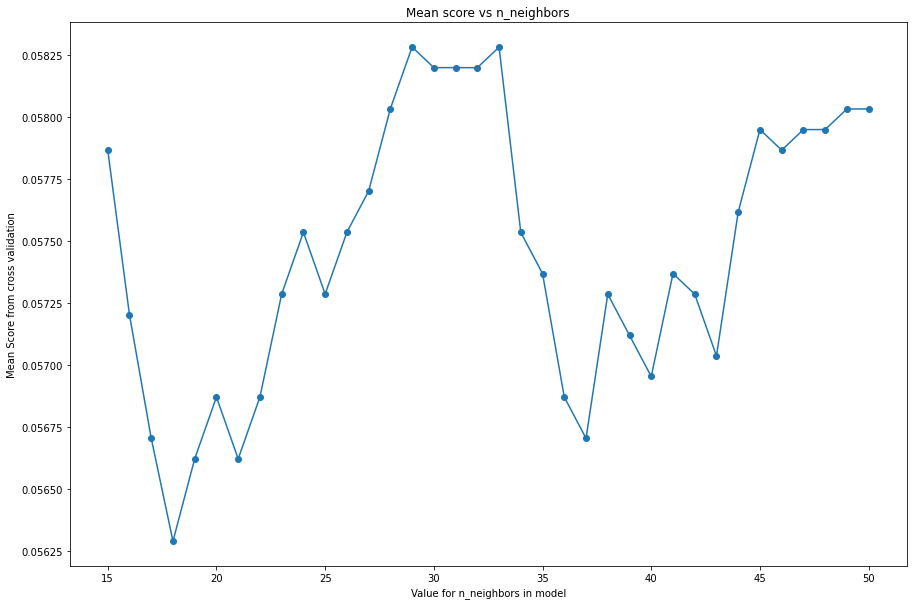

In [121]:
knn_model = KNeighborsClassifier(weights='distance')
test_k = range(15,50+1)
params=[{
    'n_neighbors': test_k,
    # 'weights': ['uniform', 'distance']
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()
tested_k = gs_knn.cv_results_['param_n_neighbors'].tolist()

fig, ax = plt.subplots()
ax.plot(tested_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()


In [122]:
max_score = max(result_k)
index_of_max = result_k.index(max_score)
optimal_k_val = tested_k[index_of_max]
optimal_k_val

29

In [123]:
knn_model = KNeighborsClassifier(weights='distance', n_neighbors=optimal_k_val)
knn_trained = knn_model.fit(x_train, y_train)
knn_model.score(x_test,y_test)

0.05579078455790785

Indicitive of clustering based on candidate expenditure

I should try to remake the first 2 models but with only 1 data point for each candidate

In [124]:
import re
candidate_election_res = []
spending_election_df = spending_member_info_2_party.copy()
for index, row in spending_election_df.iterrows():
    candidate_res = (election_data[election_data['candidate'].str.contains(row['LASTNAME'], flags=re.IGNORECASE) & election_data['state'].str.contains(row['STATE'], flags=re.IGNORECASE)])
    if not candidate_res.empty:
        spending_election_df.loc[index, 'FIRST_ELECTED'] = candidate_res['year'].max() - int((row['TERMS'] - 1) * 2)

spending_election_df.dropna(subset=['FIRST_ELECTED'], inplace=True)

spending_election_df = spending_election_df[spending_election_df['FIRST_ELECTED'] >= 2010]
spending_election_df

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL,TERMS,LASTNAME,FIRSTNAME,PARTY,STATE,FIRST_ELECTED
8,A000364,21911.470000,104002.581667,4466.935000,13644.785000,24247.825000,8708.440000,2729.533333,2411.126667,0.0,0.000000,0.000000,0.000000,0.0,1.0,Adler,John H.,Democratic,New Jersey,2012.0
10,A000366,16253.856364,147577.518182,4433.100909,11251.666364,21953.159091,10552.740909,5559.957273,3226.480000,0.0,0.000000,0.000000,0.000000,0.0,1.0,Adams,Sandy,Republican,Florida,2010.0
11,A000369,3094.296486,300068.376216,24097.306757,15600.166486,4826.799189,15530.330541,10325.584595,226989.480000,0.0,0.000000,781.893243,22700.353784,0.0,6.0,Amodei,Mark E.,Republican,Nevada,2010.0
12,A000370,9334.851250,365334.370417,18330.517500,7960.553750,14187.623750,12435.009167,22573.135417,376278.412500,0.0,0.000000,1210.616667,28799.856667,0.0,5.0,Adams,Alma S.,Democratic,North Carolina,2012.0
13,A000371,3802.029565,378684.991304,24271.592174,9854.430435,15782.056522,15231.071739,12741.463913,393611.773478,0.0,0.000000,935.060870,38530.816087,0.0,4.0,Aguilar,Pete,Democratic,California,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,Y000063,17168.404000,206607.326571,14897.210571,18849.428857,25842.045714,11268.846286,5939.567429,91697.753429,0.0,0.000000,457.405429,7176.635143,0.0,4.0,Yoder,Kevin,Republican,Kansas,2012.0
866,Y000065,4116.539688,298805.577188,17447.323125,8825.123750,7179.720312,14188.968125,10682.153750,244929.378750,0.0,0.000000,484.918125,19315.641563,0.0,4.0,Yoho,Ted S.,Republican,Florida,2012.0
867,Y000066,11272.579444,236393.313333,16917.312222,10016.435556,8820.207778,12847.712222,12529.895556,175452.861667,0.0,0.388889,947.271667,17889.126111,0.0,2.0,Young,David,Republican,Iowa,2018.0
868,Z000017,22455.262917,362481.625833,13059.878333,7506.778333,19181.431667,19418.380417,8814.332083,374399.791250,0.0,106.994583,1232.522500,34375.121667,0.0,4.0,Zeldin,Lee M.,Republican,New York,2014.0


Here we have the spending dataframe from before, but now with the election data added. The "FIRST_ELECTED" column contains the election in which each member of the House was first elected. Since we are only concerned with evaluating the spending patterns of new cohorts of members of Congress, we need to have spending data for their entire congressional tenure - meaning that we need to drop any rows where "FIRST_ELECTED" is NaN (since these people were elected before 2010 and not subsequently re-elected), and any members whose first term started before 2010. 

As an example of this, we can generate violin plots of each cohort's spending on different categories. For example, we'll plot personnel compensation and travel. 

Text(0.5, 1.0, 'Cohorts of freshmen members of congress and their spending on personnel compensation')

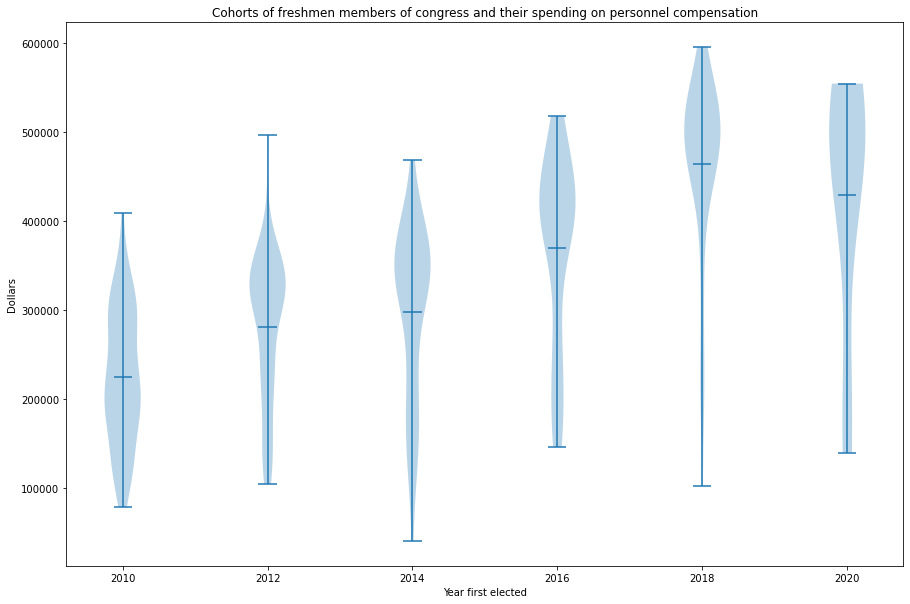

In [138]:
fig, ax = plt.subplots()
spending_cohort = []
for year in spending_election_df.FIRST_ELECTED.unique():
    spending_cohort.append(spending_election_df[spending_election_df.FIRST_ELECTED.eq(year)]['PERSONNEL COMPENSATION'])

ax.violinplot(spending_cohort, spending_election_df['FIRST_ELECTED'].unique(), showmeans=True)
ax.set_xlabel("Year first elected")
ax.set_ylabel("Dollars")
ax.set_title("Cohorts of freshmen members of congress and their spending on personnel compensation")

Text(0.5, 1.0, 'Cohorts of freshmen members of congress and their spending on travel')

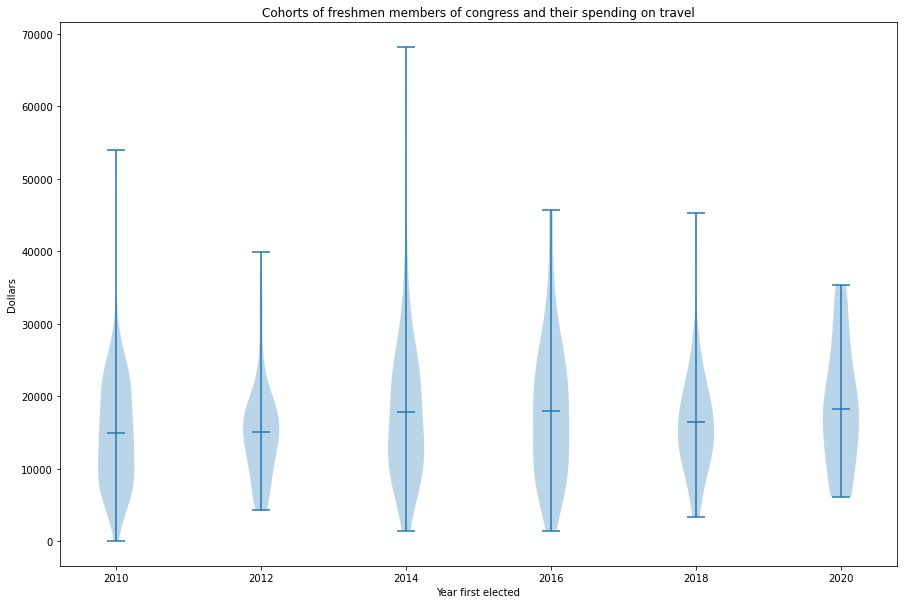

In [141]:
fig, ax = plt.subplots()
spending_cohort = []
for year in spending_election_df.FIRST_ELECTED.unique():
    spending_cohort.append(spending_election_df[spending_election_df.FIRST_ELECTED.eq(year)]['TRAVEL'])

ax.violinplot(spending_cohort, spending_election_df['FIRST_ELECTED'].unique(), showmeans=True)
ax.set_xlabel("Year first elected")
ax.set_ylabel("Dollars")
ax.set_title("Cohorts of freshmen members of congress and their spending on travel")

We can see that personnel compensation was significantly higher for members of congress initially elected in 2018. From here, we can suggest our null hypothesis (the default condition): that there is no correlation between the year a member of the House was initially elected and the amount they paid their staff. 

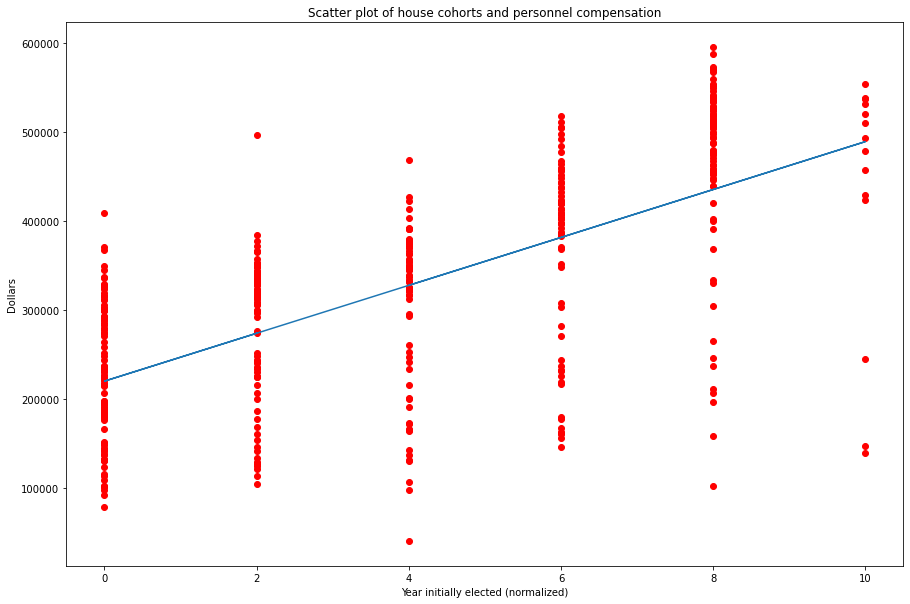

In [156]:
norm_first_elected = spending_election_df['FIRST_ELECTED'] - 2010
plt.plot(norm_first_elected, spending_election_df['PERSONNEL COMPENSATION'], 'ro')
plt.title("Scatter plot of house cohorts and personnel compensation")
plt.xlabel("Year initially elected (normalized)")
plt.ylabel("Dollars")
(m, b) = np.polyfit(norm_first_elected.values, spending_election_df['PERSONNEL COMPENSATION'].values, 1)
plt.plot(norm_first_elected.values, b + m * norm_first_elected.values, '-')
plt.show()